In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# data from linear combination of latent variables + additional noise
# for this instance, 3 latent variables 9 observed.
# each latent variable is assumed to be independent and distributed normally with mean 0 and variance 1
np.random.seed(42)
#generate 200 points from each latent distribution
latent_1 = np.random.normal(0, 1, 200)
latent_2 = np.random.normal(0, 1, 200)
latent_3 = np.random.normal(0, 1, 200)
#the strength of each latent variables effect on the observed variables
transformation_matrix = np.array([[0.3, 0.3, 0.4], [0.2, 0.3, 0.5], [0.7, 0.2, 0.1],
                                 [0.2, 0.2, 0.6], [0.1, 0.1, 0.8], [0.3, 0.6, 0.1],
                                 [0.4, 0.5, 0.1], [0.4, 0.4, 0.2], [0.9, 0.05, 0.05]])
#creating points out of the combination of latent variables weighted by their strengths
latent_matrix = np.column_stack([latent_1, latent_2, latent_3])
combined_points = np.dot(latent_matrix, transformation_matrix.T)

#add noise that we also assume is normally distributed
generated_data = combined_points + np.random.normal(0, 0.2, (200, 9))

#create dataframe
cols = [f'Variable {x+1}' for x in range(9)]
data_df = pd.DataFrame(generated_data, columns = cols)

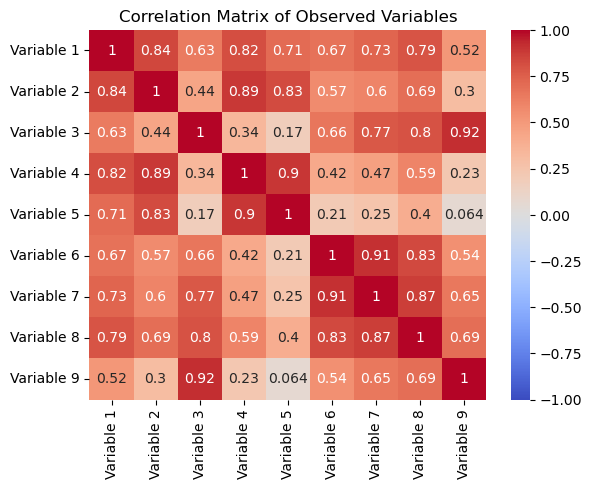

In [7]:
plt.figure()
sns.heatmap(data_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Observed Variables")
plt.show()

In [8]:
def e_step(lambda_, psi, data):
    psi_inverse = np.linalg.inv(psi)
    inner_inversion = np.linalg.inv(np.eye(lambda_.shape[1]) + (lambda_.T @ psi_inverse.T @ lambda_))
    beta_woodbury_inversion = psi_inverse - (psi_inverse @ lambda_) @ inner_inversion @ lambda_.T @ psi_inverse
    beta = lambda_.T @ beta_woodbury_inversion
    print(beta.shape)
    
    first_mom = beta @ data.T
    
    print(first_mom.shape)
    
    second_mom = np.eye(lambda_.shape[1]) - ((beta @ lambda_) + (beta @ data.T @ data @ beta.T))
    
    print(second_mom.shape)
    
    
    return first_mom, second_mom

In [9]:
def m_step(data, first_mom, second_mom):
    lambda_hat = (data.T @ first_mom.T) @ (np.linalg.inv(data.shape[0] * second_mom))
    psi = np.mean(data ** 2 - (lambda_hat @ first_mom @ data), axis = 0)
    psi_hat = (1/data.shape[0]) * np.diag(psi)
    return lambda_hat, psi_hat

In [10]:
n = data_df.shape[1]  # Number of variables
lambda_ = np.ones((n, 3))
psi = np.eye(n)
for iteration in range(1000):
    # Expectation Step
    Ez_z, Ez_zx = e_step(lambda_, psi, data_df)

    # Maximization Step
    lambda_new, psi_new = m_step(data_df, Ez_z, Ez_zx)

    # Check for convergence
    if np.allclose(lambda_, lambda_new, atol=1e-6) and np.allclose(psi, psi_new, atol=1e-6):
        print(f"Converged after {iteration+1} iterations.")
        break
    print(lambda_)
    print(psi)
    # Update parameters
    lambda_, psi = lambda_new, psi_new
    print(lambda_)
    print(psi)

(3, 9)
(3, 200)
(3, 3)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                   0         1         2
Variable 1 -0.004857 -0.004857 -0.004857
Variable 2 -0.004839 -0.004839 -0.004839
Variable 3 -0.005737 -0.005737 -0.005737
Variable 4 -0.004812 -0.004812 -0.004812
Variable 5 -0.004709 -0.004709 -0.004709
Variable 6 -0.005448 -0.005448 -0.005448
Variable 7 -0.005471 -0.005471 -0.005471
Variable 8 -0.005401 -0.005401 -0.005401
Variable 9 -0.005482 -0.005482 -0.005482
[[nan  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. nan  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan  0.  0.  

ValueError: matrices are not aligned

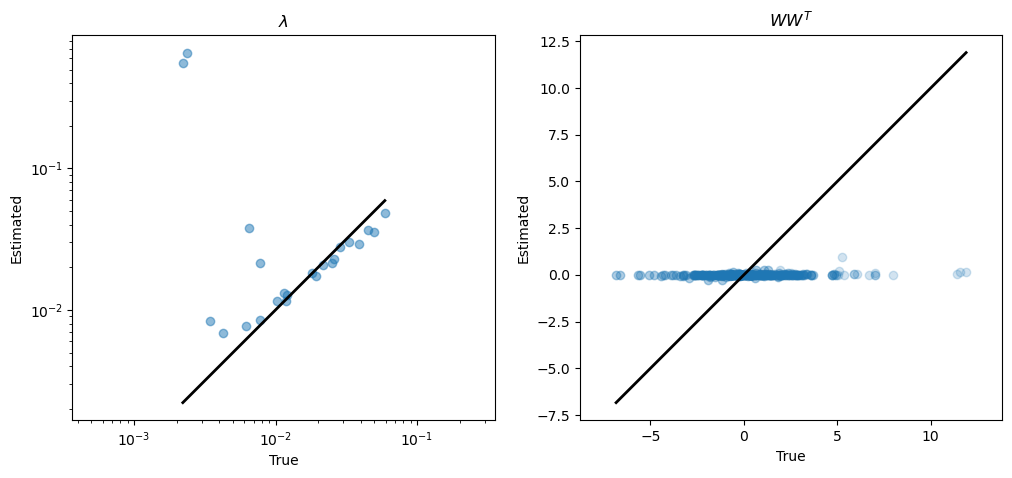

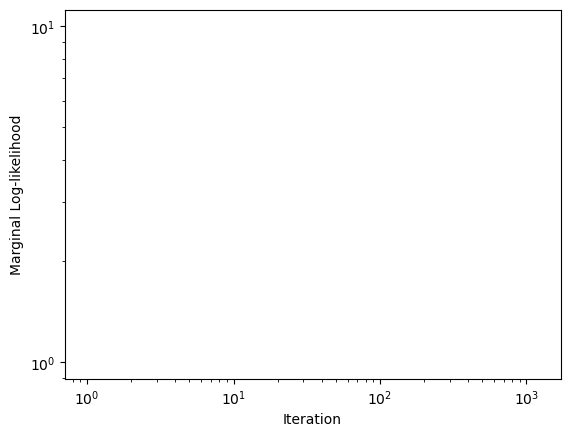